# Exercise 1: Linear Regression

The *bodyfat* data set contains several body measurements that can be done using a scale and a tape measure. These can be used to predict the body fat percentage (`body.fat` column). Measuring body fat requires a special apparatus; if our resulting model fits well, we have a low-cost alternative. The measurements are age, weight, height, BMI, neck, chest, abdomen, hip, thigh, knee, ankle, bicep, forearm, and wrist.

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

,body.fat,age,weight,height,BMI,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,12.6,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


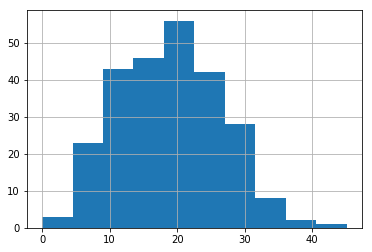

In [2]:
bodyfat = pd.read_csv('datasets/bodyfat.csv')

bodyfat['body.fat'].hist()
bodyfat.head()

## Task 1

*Create a function that takes a data matrix $\mathbf{X} \in \mathbb{R}^{n \times m}$ of measurements and a vector $\mathbb{y} \in \mathbb{R}^n$ of body fat content. The function should return the **ordinary least squares (OLS)** estimate of the coefficients $\beta$ (including the intercept).*

The solution is very similar to the [example on linear regression](../lectures/02_linear_regression_low_level_tensor_board.ipynb). The main difference is that we standardize the training data to have zero mean and unit variance by substracing the empirical mean and dividing by the standard deviation. This ensures that all our predictors are on the same scale, which has two major advantages:

1. We can directly compare the coefficients (slopes) to determine which feature is most predictive.
2. The optimization becomes numerically more stable and less dependent on choosing the right scale for the learning rate, which would lead divergence otherwise.

In [3]:
import numpy as np

def fit_ols_simple(X, y, logdir, learning_rate=0.95, steps=100, dtype=np.float64, verbose=False):
    """Fit an ordinary least squares model `y = intercept + slope * X`

    Parameters
    ----------
    X : array-like, shape=(n_samples,)
        A vector of values for a single feature.

    y : array-like, shape=(n_samples,)
        A vector of output variables to regress on.
        
    logdir : str
        Path to directoty where to write files
        for TensorBoard to.

    learning_rate : float
        The learning rate used in gradient descent.

    steps : int
        Number of gradient descent iterations.

    dtype : np.float32 | np.float64
        Which floating point type to use.

    verbose : bool
        Whether to enable verbose output.

    Returns
    -------
    predict_func : callable
        A function to perform predictions
        using the estimated model.

    intercept : float
        The value of the intercept.

    slope : float
        The value of the slope.
    """
    x = np.asarray(X, dtype=dtype)
    y = np.asarray(y, dtype=dtype)

    # create empty graph and session
    tf.reset_default_graph()
    sess = tf.Session()

    # placeholders for the input
    with tf.name_scope('input'):
        x_placeholder = tf.placeholder(dtype, shape=[None], name='x-input')
        y_placeholder = tf.placeholder(dtype, shape=[None], name='y-input')

    # standardize the features by substracting the mean
    # dividing by the standard deviation
    with tf.name_scope('preprocessing'):
        x_mean, x_var = tf.nn.moments(x_placeholder, axes=[0])
        x_train_std = (x_placeholder - x_mean) / tf.sqrt(x_var)

    # create the linear predictor and loss function to be minimized
    # note that we compute the intercept in closed form and only
    # the slope is optimized via gradient descent.
    with tf.name_scope('model'):
        with tf.name_scope('predictor'):
            slope = tf.Variable(0.0, name='slope', dtype=dtype)
            intercept = tf.reduce_mean(y_placeholder)
            y_train = intercept + slope * x_train_std

        # squared error loss
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.square(y_train - y_placeholder))

        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            tf.summary.scalar('slope', slope)
        summary_op = tf.summary.merge_all()

    # create a gradient descent optimizer
    with tf.name_scope('optimizer'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    with tf.name_scope('predict'):
        # retrieve values of mean, variance, and intercept
        # used during training
        val_x_mean, val_x_var, val_intercept = sess.run(
            [x_mean, x_var, intercept],
            feed_dict={x_placeholder: X,
                       y_placeholder: y})

        # create a function for prediction, where we standardize
        # the data the same way as in training.
        with tf.name_scope('preprocessing'):
            x_test_std = (x_placeholder - tf.constant(val_x_mean)) / tf.constant(np.sqrt(val_x_var))

        # do the prediction
        with tf.name_scope('prediction'):
            y_pred = tf.constant(val_intercept) + x_test_std * slope

    # initialize variable slope
    sess.run(tf.global_variables_initializer())

    # create writer to serialize summary statistics during training
    writer = tf.summary.FileWriter(logdir)
    writer.add_graph(sess.graph)

    # do the training
    for step in range(steps):
        summary_result, _ = sess.run([summary_op, train_step], 
                                     feed_dict={x_placeholder: x,
                                                y_placeholder: y})
        # write the summary data to disk
        writer.add_summary(summary_result, step)

        if verbose and step % 10 == 0:
            print(sess.run(slope))

    # close the writer when we're finished using it
    writer.close()

    def do_predict(new_x):
        return sess.run(y_pred, feed_dict={x_placeholder: new_x})

    val_slope = sess.run(slope)
    return do_predict, val_intercept, val_slope

## Task 2

*Create multiple models that predict the amount of body fat based on one of the 14 features mentioned above, respectively. For each model create a scatter plot which depicts the data and the model.*

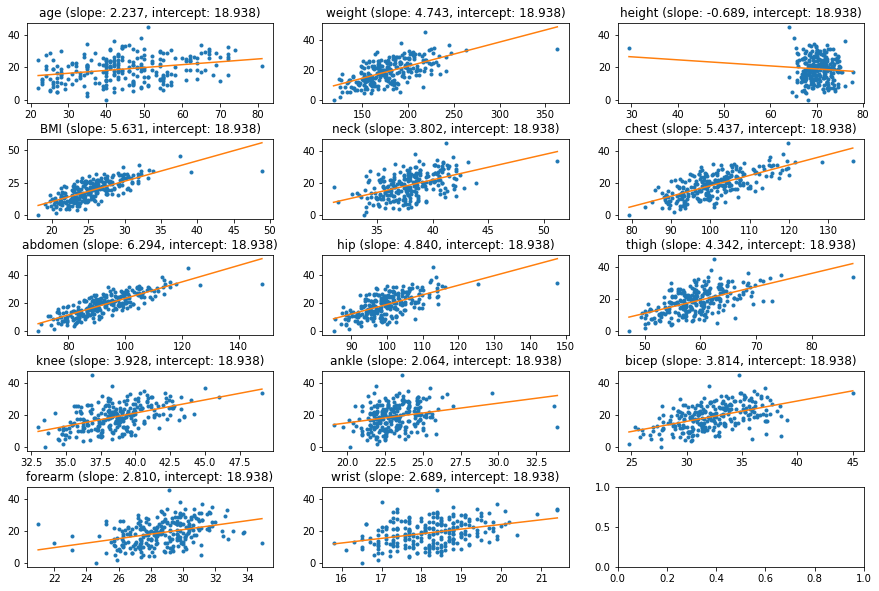

In [4]:
bodyfat_features = bodyfat.drop('body.fat', axis=1)
fig, axs = plt.subplots(5, 3, figsize=(15, 10), gridspec_kw={'hspace': 0.45})
for i, (name, values) in enumerate(bodyfat_features.iteritems()):
    f, intercept, slope = fit_ols_simple(values, bodyfat['body.fat'], 'graphs/02_{}'.format(name))

    ax = axs.flat[i]
    x = np.linspace(values.min(), values.max(), 100)
    ax.plot(values, bodyfat['body.fat'], '.')
    ax.plot(x, f(x))
    ax.set_title('%s (slope: %.3f, intercept: %.3f)'% (name, slope, intercept))

### Compare against scikit-learn

As a sanity check we compare our solution against the ordinary least squares estimator from scikit-learn, which computes the estimated coefficients in closed form and does not rely on gradient descent.

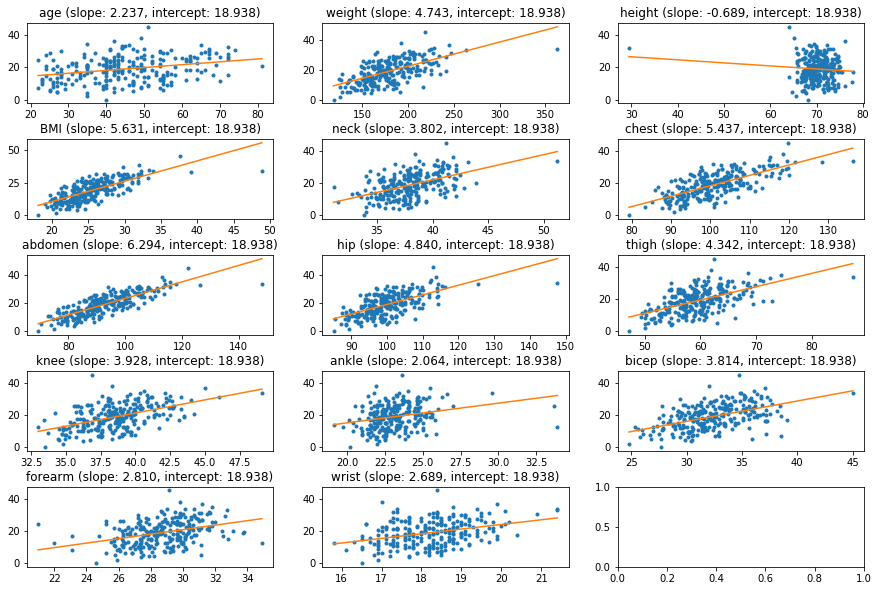

In [5]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
regressor = Ridge(alpha=0)
estimator = make_pipeline(scaler, regressor)

fig, axs = plt.subplots(5, 3, figsize=(15, 10), gridspec_kw={'hspace': 0.45})
for i, name in enumerate(bodyfat_features.columns):
    values = bodyfat.loc[:, name:name]
    estimator.fit(values, bodyfat['body.fat'])

    ax = axs.flat[i]
    x = np.linspace(values.min(), values.max(), 100)
    ax.plot(values, bodyfat['body.fat'], '.')
    ax.plot(x, estimator.predict(x[:, np.newaxis]))
    ax.set_title('%s (slope: %.3f, intercept: %.3f)'% (name, regressor.coef_[0], regressor.intercept_))

## Task 3

*Create a single model that contains all of the 14 features mentioned above. Which features have the highest/lowest coefficients?*

For the multivariate model with $m$ features, the input becomes a matrix (2-D tensor) instead of a vector (1-D tensor) and instead of just slope and intercept, we need to estimate intercept and $m$ coefficients.
Hence, our linear predictor becomes:
$$
y_i = \text{intercept} + \sum_{j=1}^m x_{ij} \beta_j ,
$$
or in matrix form
$$
\mathbf{y} = \text{intercept} + \mathbf{X} \beta .
$$

To compute the matrix-vector product $\mathbf{X} \beta$ we will be using ``tf.matmul``.

In [6]:
import numpy as np

def fit_ols_multivariate(X, y, logdir, learning_rate=0.1, steps=2000, dtype=np.float64, verbose=False):
    """Fit multivariate ordinary least squares model `y = intercept + X @ coefficients`,
    where `@` denotes the matrix multiply.

    Parameters
    ----------
    X : array-like, shape=(n_samples, n_features)
        A vector of values for a single feature.

    y : array-like, shape=(n_samples,)
        A vector of output variables to regress on.
        
    logdir : str
        Path to directoty where to write files
        for TensorBoard to.

    learning_rate : float
        The learning rate used in gradient descent.

    steps : int
        Number of gradient descent iterations.

    dtype : np.float32 | np.float64
        Which floating point type to use.

    verbose : bool
        Whether to enable verbose output.

    Returns
    -------
    predict_func : callable
        A function to perform predictions
        using the estimated model.

    intercept : float
        The value of the intercept.

    coef : ndarray, shape=(n_features,)
        The value of the coefficients.
    """
    x = np.asarray(X, dtype=dtype)
    y = np.asarray(y, dtype=dtype)
    n_features = x.shape[1]

    # create empty graph and session
    tf.reset_default_graph()
    sess = tf.Session()

    # placeholders for the input
    with tf.name_scope('input'):
        x_placeholder = tf.placeholder(dtype, shape=[None, n_features], name='x-input')
        y_placeholder = tf.placeholder(dtype, shape=[None], name='y-input')

    # standardize the features by substracting the mean
    # dividing by the standard deviation
    with tf.name_scope('preprocessing'):
        x_mean, x_var = tf.nn.moments(x_placeholder, axes=[0])
        x_train_std = (x_placeholder - x_mean) / tf.sqrt(x_var)

    # create the linear predictor and loss function to be minimized
    # note that we compute the intercept in closed form and only
    # the coefficients are optimized via gradient descent.
    with tf.name_scope('model'):
        with tf.name_scope('predictor'):
            coef = tf.Variable(np.zeros((n_features, 1)), name='coef', dtype=dtype)
            intercept = tf.reduce_mean(y_placeholder)
            y_train = intercept + tf.reshape(tf.matmul(x_train_std, coef), shape=[-1])

        # squared error loss
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.square(y_train - y_placeholder))

        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            tf.summary.histogram('coef', coef)
        summary_op = tf.summary.merge_all()

    # create a gradient descent optimizer
    with tf.name_scope('optimizer'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    with tf.name_scope('predict'):
        # retrieve values of mean, variance, and intercept
        # used during training
        val_x_mean, val_x_var, val_intercept = sess.run(
            [x_mean, x_var, intercept],
            feed_dict={x_placeholder: X,
                       y_placeholder: y})

        # create a function for prediction, where we standardize
        # the data the same way as in training.
        with tf.name_scope('preprocessing'):
            x_test_std = (x_placeholder - tf.constant(val_x_mean)) / tf.constant(np.sqrt(val_x_var))
            
        # do the prediction
        with tf.name_scope('prediction'):
            y_pred = tf.constant(val_intercept) + tf.reshape(tf.matmul(x_test_std, coef), shape=[-1])

    # initialize coefficients
    sess.run(tf.global_variables_initializer())
    
    # create writer to serialize summary statistics during training
    writer = tf.summary.FileWriter(logdir)
    writer.add_graph(sess.graph)

    # do the training
    for step in range(steps):
        summary_result, _ = sess.run([summary_op, train_step], 
                                     feed_dict={x_placeholder: x,
                                                y_placeholder: y})
        # write the summary data to disk
        writer.add_summary(summary_result, step)

        if verbose and step % 10 == 0:
            print(sess.run(coef))

    # close the writer when we're finished using it
    writer.close()

    def do_predict(new_x):
        return sess.run(y_pred, feed_dict={x_placeholder: new_x})

    val_coef = sess.run(coef)
    return do_predict, val_intercept, val_coef

Let's train the model.

In [7]:
f, intercept, coef, = fit_ols_multivariate(
    bodyfat_features, bodyfat['body.fat'], 'graphs/02_multivariate')

coef = pd.Series(coef.ravel(), bodyfat_features.columns)

print(intercept)
print(coef)

18.9384920635
age        0.715379
weight    -2.384541
height    -0.194016
BMI        0.222114
neck      -1.079534
chest     -0.259735
abdomen    9.459245
hip       -1.451941
thigh      1.191349
knee      -0.002399
ankle      0.265915
bicep      0.447795
forearm    0.866502
wrist     -1.378269
dtype: float64


From the result above, we can see that the coefficient of *abdomen* has largest magnitude of all coefficients, consequently it has the highest impact on predicting body fat, whereas *knee* is the least important measurement.

To confirm that our results are valud, we'll compare them with the results of the scikit-learn estimator.

In [8]:
estimator.fit(bodyfat_features, bodyfat['body.fat'])
expected_coef = pd.Series(regressor.coef_, bodyfat_features.columns)
print(regressor.intercept_)
print(expected_coef)

18.9384920635
age        0.715374
weight    -2.384656
height    -0.194004
BMI        0.222113
neck      -1.079522
chest     -0.259706
abdomen    9.459251
hip       -1.451888
thigh      1.191347
knee      -0.002389
ankle      0.265919
bicep      0.447802
forearm    0.866502
wrist     -1.378265
dtype: float64
